#### scVI label transfer method

**Objective:** Run label transfer method using scVI and scANVI following tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html#Reference-mapping-with-SCANVI

v230428


In [1]:
import torch
import math

print(torch.backends.mps.is_available())

True


In [2]:
print(torch.backends.mps.is_built())

True


In [3]:
import sys
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi

Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 94705


In [5]:
url = "https://figshare.com/ndownloader/files/24539828"
adata = sc.read("pancreas.h5ad", backup_url=url)
print(adata)

  0%|          | 0.00/301M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


In [46]:
adata.obs['size_factors'].value_counts()


size_factors
1.000000    1492
0.013286       1
0.015746       1
0.012939       1
0.013945       1
            ... 
0.070177       1
0.076013       1
0.043914       1
0.090963       1
0.020973       1
Name: count, Length: 14891, dtype: int64

- Questions
> Has this data been normalized?

In [6]:
adata.obs.tech.value_counts()

tech
inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

In [7]:
# here, we are making reference and query objects from the original adata object
 
query = np.array([s in ["smartseq2", "celseq2"] for s in adata.obs.tech])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

In [8]:
# We run highly variable gene selection on the reference data and use these same genes for the query data.

sc.pp.highly_variable_genes(adata_ref, n_top_genes=2000, batch_key="tech", subset=True)

adata_query = adata_query[:, adata_ref.var_names].copy()

- Ensure GPU use

In [13]:
device = torch.device("mps")
scvi.model.SCVI.device

#there is no MPS in the lgamma function

- scVI model

In [14]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="tech", layer="counts")

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [15]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(adata_ref, **arches_params)
vae_ref.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/400:   0%|          | 1/400 [00:01<11:54,  1.79s/it, loss=1.06e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [12:05<00:00,  1.98s/it, loss=795, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:05<00:00,  1.81s/it, loss=795, v_num=1]


In [16]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


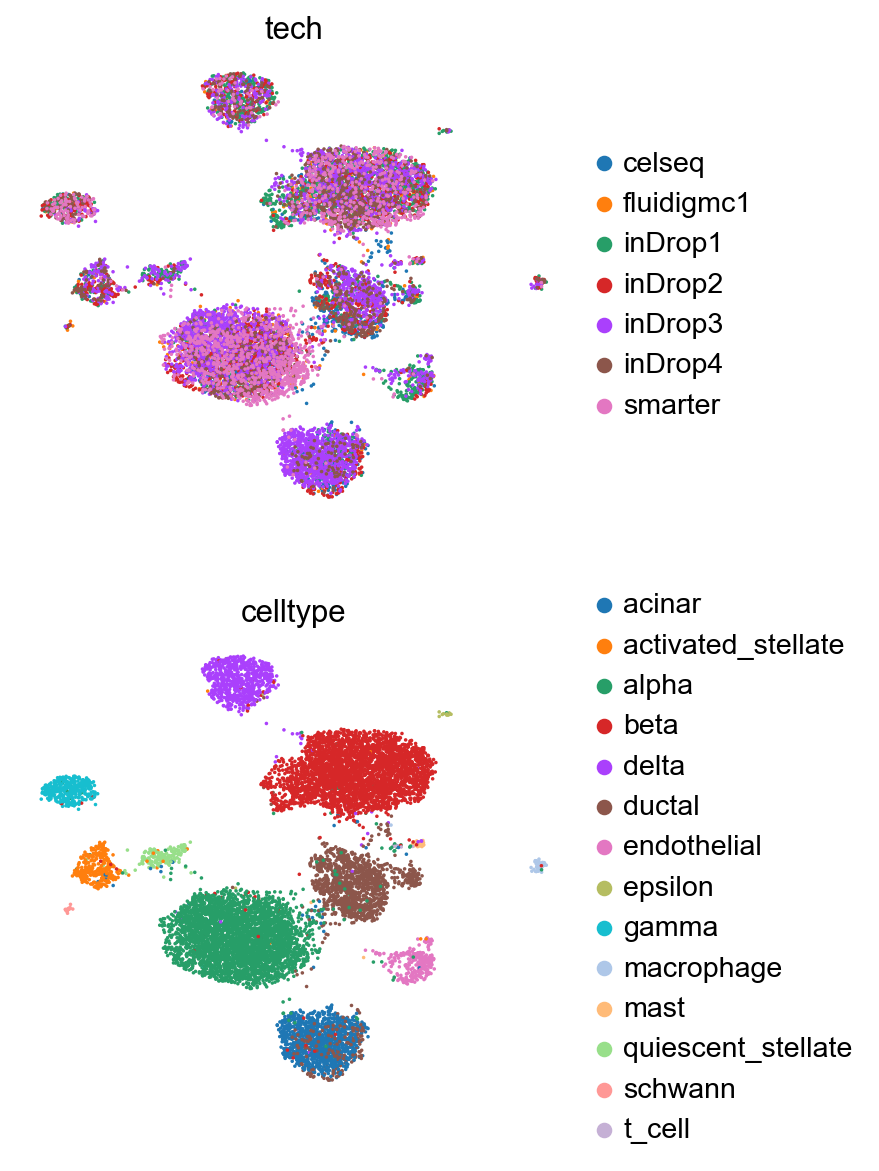

In [17]:
sc.pl.umap(
    adata_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

- scANVI model 

In [18]:
adata_ref.obs["labels_scanvi"] = adata_ref.obs["celltype"].values

In [19]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",
    labels_key="labels_scanvi",
)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [20]:
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/20:   5%|▌         | 1/20 [00:03<00:57,  3.02s/it, loss=871, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/20: 100%|██████████| 20/20 [01:02<00:00,  3.19s/it, loss=867, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it, loss=867, v_num=1]


In [21]:
adata_ref.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


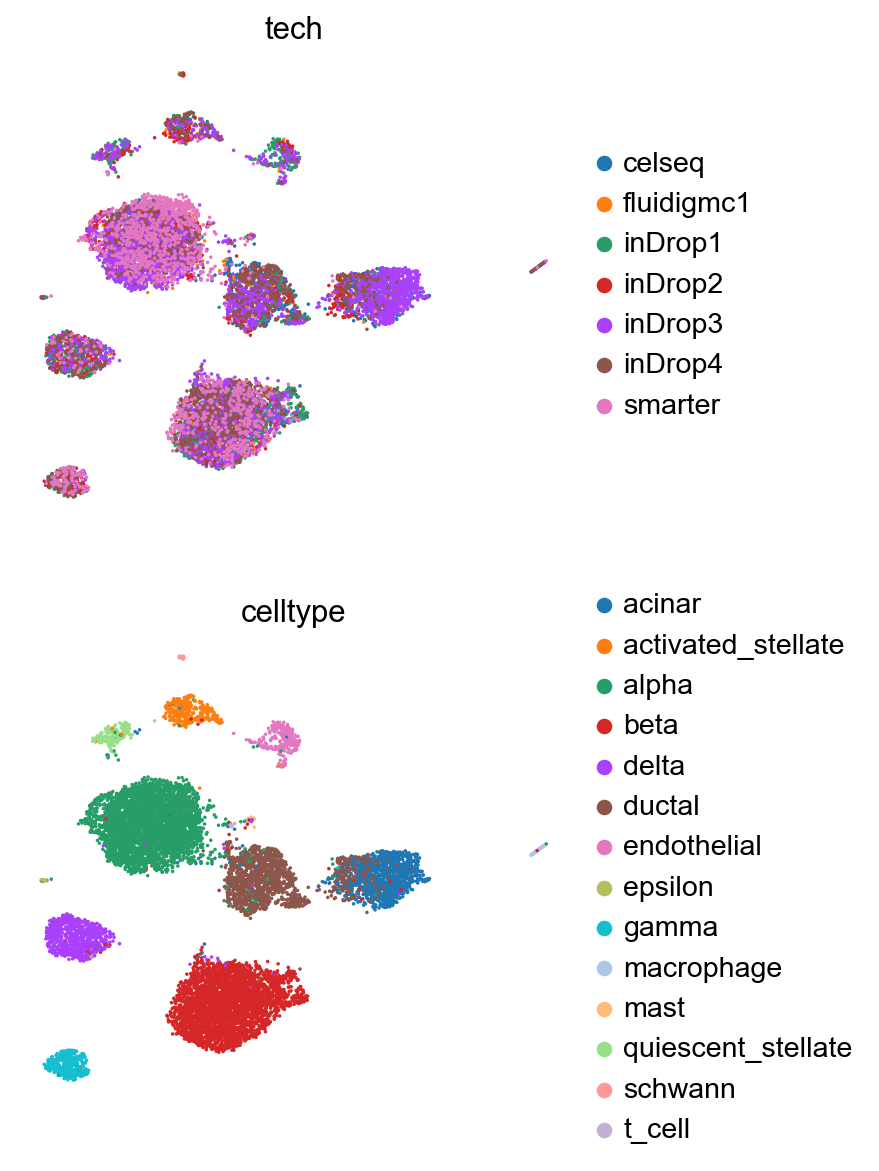

In [22]:
sc.pl.umap(
    adata_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

### Update with query

In [31]:
# save the reference model
dir_path_scan = "pancreas_model/"
vae_ref_scan.save(dir_path_scan, overwrite=True)

In [32]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

INFO     File pancreas_model/model.pt already downloaded                                                           
INFO     Found 100.0% reference vars in query data.                                                                


In [29]:
vae_ref_scan.registry_

{'scvi_version': '0.20.3',
 'model_name': 'SCANVI',
 'setup_args': {'labels_key': 'labels_scanvi',
  'unlabeled_category': 'Unknown',
  'layer': 'counts',
  'batch_key': 'tech',
  'size_factor_key': None,
  'categorical_covariate_keys': None,
  'continuous_covariate_keys': None},
 'field_registries': defaultdict(dict,
             {'X': {'data_registry': {'attr_name': 'layers',
                'attr_key': 'counts'},
               'state_registry': {'n_obs': 11703,
                'n_vars': 2000,
                'column_names': array(['A2M', 'AADAC', 'ABCA4', ..., 'ZSWIM3', 'ZSWIM4', 'ZXDA'],
                      dtype=object)},
               'summary_stats': {'n_vars': 2000, 'n_cells': 11703}},
              'batch': {'data_registry': {'attr_name': 'obs',
                'attr_key': '_scvi_batch'},
               'state_registry': {'categorical_mapping': array(['celseq', 'fluidigmc1', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4',
                       'smarter'], dtype=object),
     

In [33]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    dir_path_scan,
)

INFO     File pancreas_model/model.pt already downloaded                                                           


/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:90: UserWarning: Missing labels key labels_scanvi. Filling in with unlabeled category Unknown.
  warnings.warn(


In [34]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:01<01:46,  1.08s/it, loss=1.95e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/100:  10%|█         | 10/100 [00:09<01:20,  1.12it/s, loss=1.84e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [01:28<00:00,  1.08it/s, loss=1.79e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s, loss=1.79e+03, v_num=1]


In [35]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

Text(0, 0.5, 'Observed')

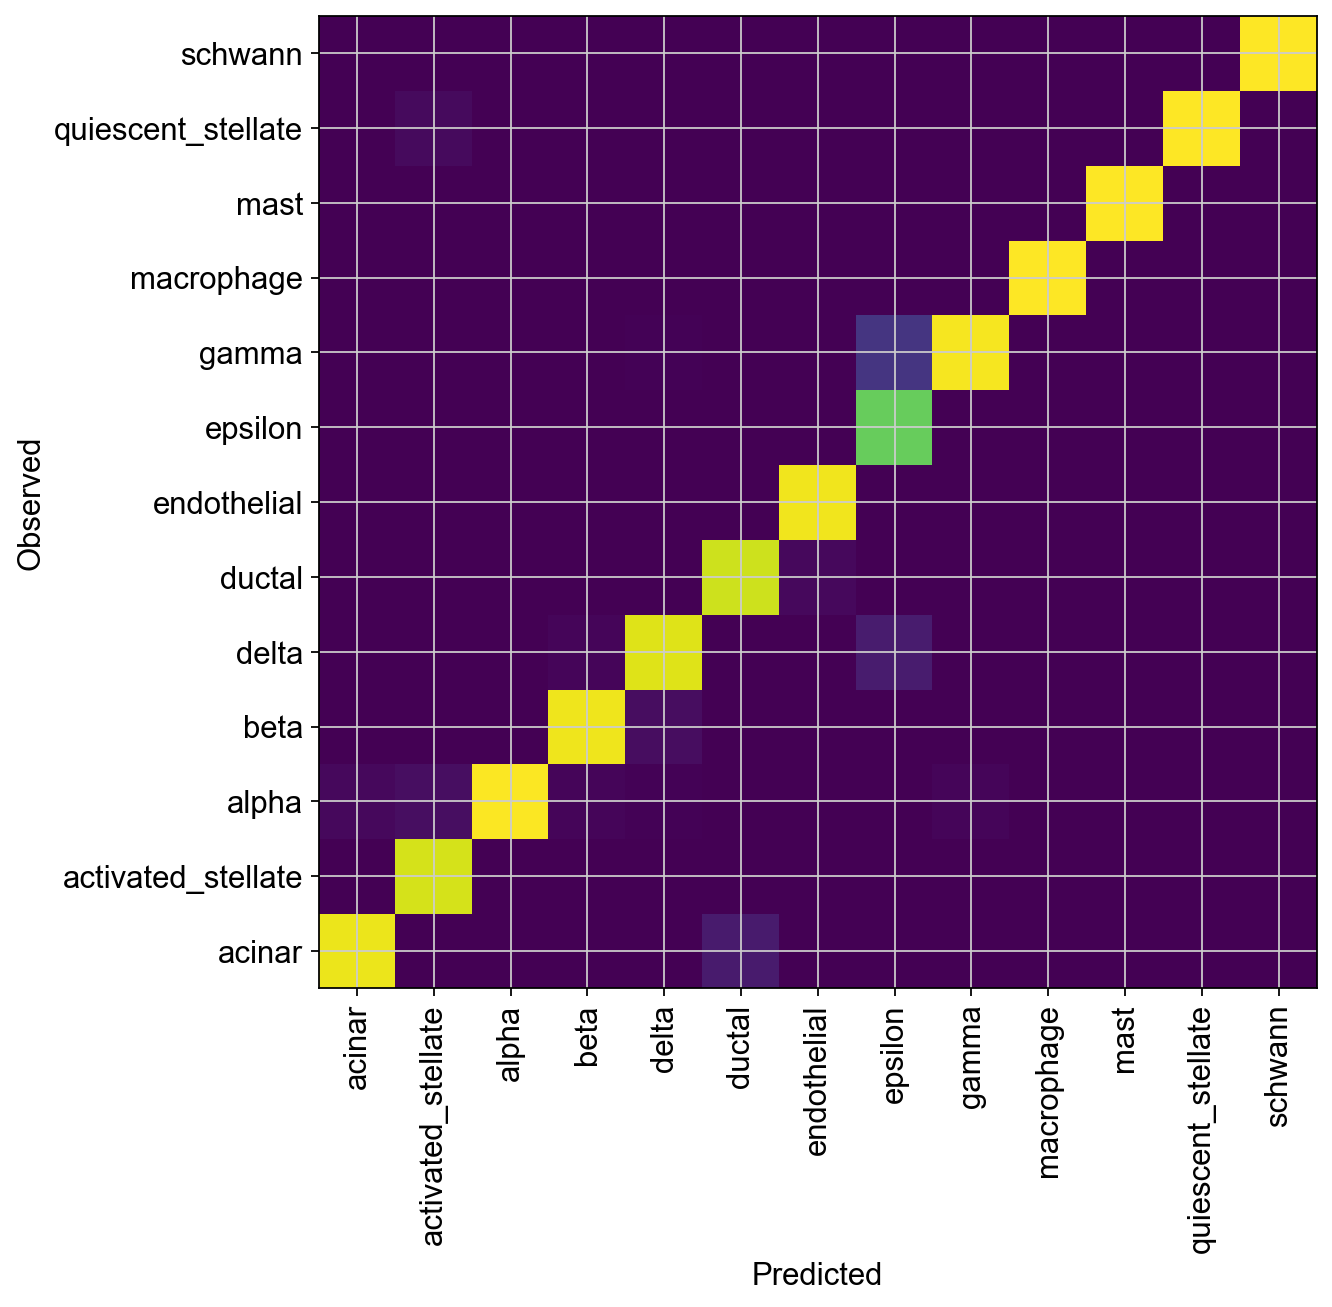

In [52]:
df = adata_query.obs.groupby(["celltype", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")



### Analyze reference and query

In [37]:
adata_full = adata_query.concatenate(adata_ref)

In [39]:
# This just makes a column in the anndata corresponding to if the data come from the reference or query sets.

adata_full.obs.batch.cat.rename_categories(["Query", "Reference"])

# Note: Removed "inplace=True" due to error

D28-1_74-0           Query
D28-1_76-0           Query
D28-1_85-0           Query
D28-2_37-0           Query
D28-2_63-0           Query
                   ...    
Sample_1594-1    Reference
Sample_1595-1    Reference
Sample_1597-1    Reference
Sample_1598-1    Reference
Sample_1600-1    Reference
Name: batch, Length: 16382, dtype: category
Categories (2, object): ['Query', 'Reference']

In [40]:
full_predictions = vae_q.predict(adata_full)
print(f"Acc: {np.mean(full_predictions == adata_full.obs.celltype)}")

adata_full.obs["predictions"] = full_predictions

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Acc: 0.9617873275546331


In [41]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


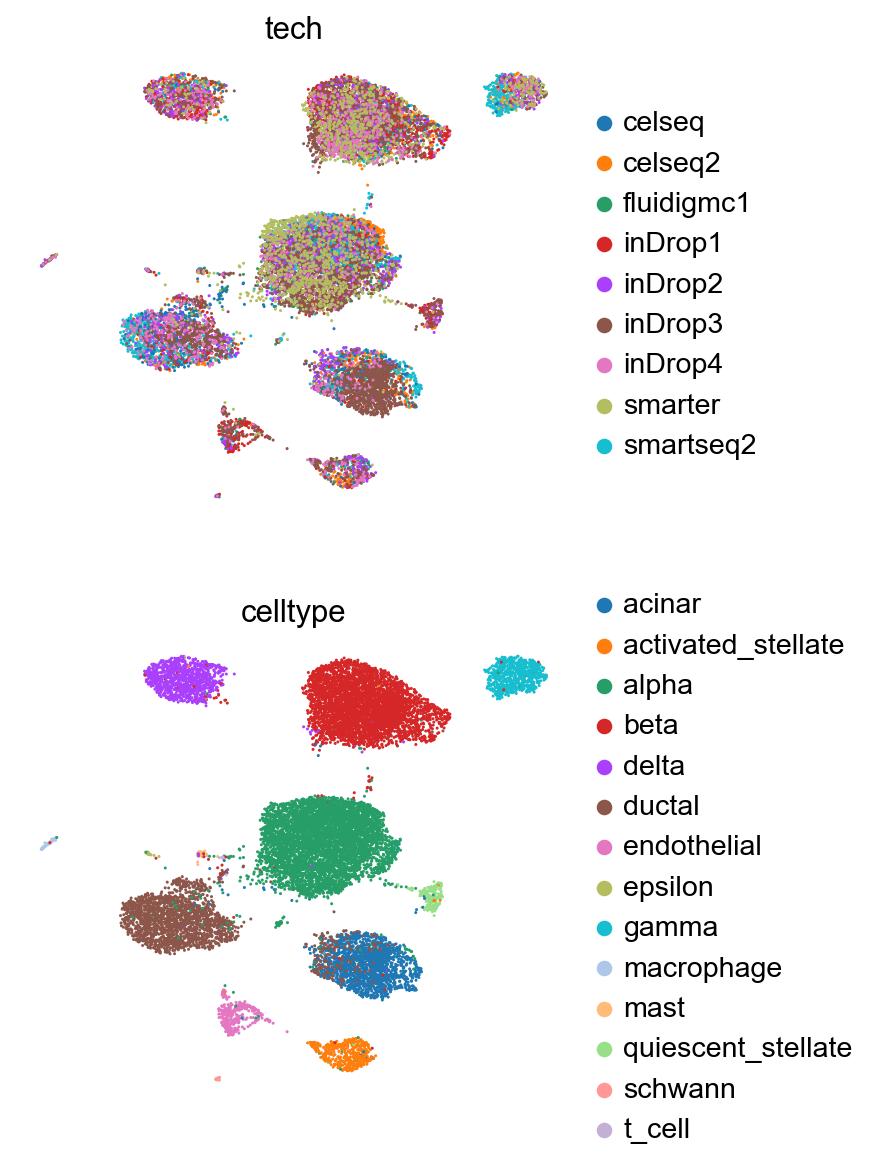

In [42]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


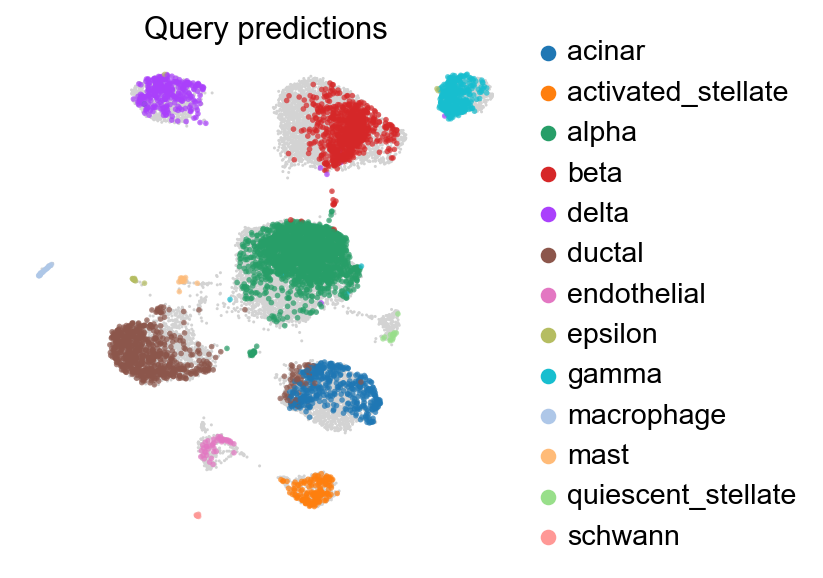

/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


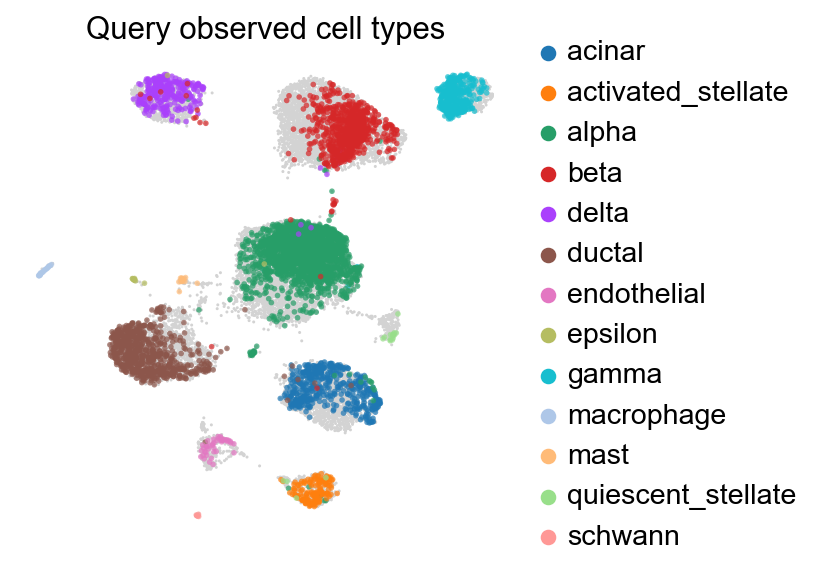

In [43]:
ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["predictions"],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["celltype"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)